In [4]:
import numpy as np
import pandas as pd
from ebmdatalab import maps
from ebmdatalab import bq

In [5]:
## Here we query our prescribing file to create a dataframe of all inhaler prescribing
sql = '''
SELECT
  pct,
  pract.name,
  presc.practice,
  AVG(total_list_size) AS list_size,
  presc.month,
  SUM(IF(form_route='powderinhalation.inhalation', ##from dmd, identifies a DPI 
      items,
      0)) AS dpi,
      SUM(IF(form_route='pressurizedinhalation.inhalation',  ##from dmd, identifies a MDI
      items,
      0)) AS mdi,
      SUM(items) AS totalinhalers,
    SUM(actual_cost) AS totalcost
   FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
  AND pract.setting=4 ## I have restricted to "normal" general practice. Review choice with team
LEFT JOIN  # is this join in the right place  review
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  pct,
  name,
  practice,  
  month
  '''


df_inhaler = bq.cached_read(sql, csv_path='boomboom.csv', use_cache=True)  # add `use_cache=False` to override
df_inhaler.head()

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost
0,15D,THE GAINSBOROUGH PRACTICE,K81059,9973.0,2015-08-01,163,295,458,14311.79
1,09W,PARKWOOD FAMILY PRACTICE,G82721,3925.0,2015-08-01,149,246,395,9174.20
2,99Q,BUCKLAND SURGERY,L83666,2971.0,2015-08-01,91,223,314,6864.87
3,07J,BOUGHTON SURGERY,D82604,3054.0,2015-08-01,60,254,314,5520.14
4,01H,CASTLEHEAD MEDICAL CENTRE,A82028,6475.0,2015-08-01,203,252,455,10416.57


In [6]:
#aggregate over 2018
ccg_last_year = df_inhaler.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[(ccg_last_year["month"]>="2018-01-01") & (ccg_last_year["month"]<="2018-12-01")]

#ccg_last_year = all_inhalers_ccg.loc[all_inhalers_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

df_inhaler["per_dpi"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)
df_inhaler["costperinh"] = (df_inhaler.totalcost/df_inhaler.totalinhalers).fillna(0)

ccg_last_year["per_dpi"] = 100*(ccg_last_year.dpi/(ccg_last_year.dpi+ccg_last_year.mdi)).fillna(0)


ccg_last_year.head()

,list_size,dpi,mdi,totalinhalers,totalcost,per_dpi
pct,,,,,,
00C,108423.333333,59653,80420,140073,3.236474e+06,42.587080
00D,292336.000000,214874,320164,535038,1.058912e+07,40.160512
00J,259779.833333,142789,214871,357660,7.242765e+06,39.923111
00K,297508.166667,183635,292898,476533,1.009143e+07,38.535631
00L,325704.916667,221356,247103,468459,1.021576e+07,47.251947


C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


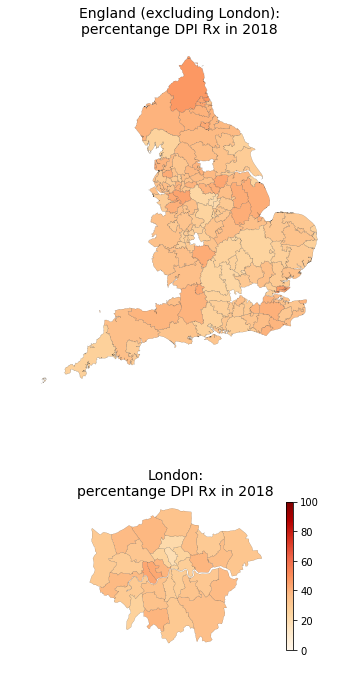

In [7]:
ccg_last_year.columns = ['list_size', 'dpi', 'mdi', 'totalinhalers', 'totalcost', 'per_dpi']  # The CCG column must be named 'pct'
plt = maps.ccg_map(ccg_last_year, title="percentange DPI Rx in 2018", column='per_dpi', separate_london=True)
plt.show()